In [2]:
import pandas as pd
from datetime import datetime, timedelta

CSV Laden

In [3]:
import_file = "../Import/transactions_202403201540.csv"
date_columns = ["drive_in_at", "drive_out_at"]
df = pd.read_csv(import_file, parse_dates=date_columns)
df.head()

,gate_id_in,drive_in_at,drive_out_at,duration,id,kind
0,68,2024-01-01 05:54:08,2024-01-01 15:41:13,587,3371593,D/Y
1,68,2024-01-01 06:03:44,2024-01-01 06:08:09,5,3371607,K
2,68,2024-01-01 07:56:45,2024-01-01 11:48:14,232,3371761,D/Y
3,68,2024-01-01 09:20:34,2024-01-01 09:25:12,5,3371881,K
4,68,2024-01-01 09:49:06,2024-01-01 11:35:33,106,3371931,D/Y


Welche Parkplatz IDs gibt es?

In [4]:
df['gate_id_in'].drop_duplicates()

0        68
17091    70
23252    72
29646    78
Name: gate_id_in, dtype: int64

IDs der Parkplätze

In [5]:
parking_lots = [
    {
        'name': "Kaiservilla",
        'gate_id': 68
    },
    {
        'name': "Rechensteg",
        'gate_id': 70
    },
    {
        'name': "Traunkai",
        'gate_id': 72
    },
    {
        'name': "Kongress",
        'gate_id': 78
    },
]

In [6]:
ts_start = df['drive_in_at'].min()
ts_end = df['drive_out_at'].max()

print("Data available from", ts_start, "to", ts_end)

Data available from 2024-01-01 00:26:12 to 2024-03-12 18:53:53


In [7]:
def round_to_nearest_hour(date):
    if date.minute >= 30:
        # add an hour and remove mins and secs
        return date + timedelta(hours=1) - timedelta(minutes=date.minute, seconds=date.second)
    else:
        # remove mins and secs
        return date - timedelta(minutes=date.minute, seconds=date.second)


def get_data_by_hour(data):

    # key: the_hout, value: {delta, counter}
    data_by_hour = {}
    
    start = round_to_nearest_hour(data['drive_in_at'].min())
    end = round_to_nearest_hour(data['drive_out_at'].max())
    
    # better hourly timeline

    # going in
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_in_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] + 1
        #print("In", row["drive_in_at"], "around", hour, data_by_hour[hour])
        
    #going out
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_out_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] - 1
        #print("Out", row["drive_out_at"], "around", hour, data_by_hour[hour])
        
    
    # add empty windows for smooth x axis
    current_timestamp = start.replace(minute=0, second=0, microsecond=0)
    end_timestamp = end.replace(minute=0, second=0, microsecond=0)

    while current_timestamp < end_timestamp:
        #print(current_timestamp)
        current_timestamp += timedelta(hours=1)
        if not current_timestamp in data_by_hour:
            data_by_hour[current_timestamp] = {
                'delta': 0,
                'counter': 0
            }
    
        
    # sort by date
    data_by_hour = dict(sorted(data_by_hour.items()))

    # sliding window counter algo
    current_count = 0
    for key in data_by_hour:
        current_count = current_count + data_by_hour[key]['delta']
        data_by_hour[key]['counter'] = current_count
        
    return data_by_hour


get_data_by_hour(df)

{Timestamp('2024-01-01 00:00:00'): {'delta': 1, 'counter': 1},
 Timestamp('2024-01-01 01:00:00'): {'delta': 2, 'counter': 3},
 Timestamp('2024-01-01 02:00:00'): {'delta': 0, 'counter': 3},
 Timestamp('2024-01-01 03:00:00'): {'delta': 1, 'counter': 4},
 Timestamp('2024-01-01 04:00:00'): {'delta': 1, 'counter': 5},
 Timestamp('2024-01-01 05:00:00'): {'delta': 0, 'counter': 5},
 Timestamp('2024-01-01 06:00:00'): {'delta': 1, 'counter': 6},
 Timestamp('2024-01-01 07:00:00'): {'delta': 2, 'counter': 8},
 Timestamp('2024-01-01 08:00:00'): {'delta': 4, 'counter': 12},
 Timestamp('2024-01-01 09:00:00'): {'delta': 0, 'counter': 12},
 Timestamp('2024-01-01 10:00:00'): {'delta': 3, 'counter': 15},
 Timestamp('2024-01-01 11:00:00'): {'delta': 8, 'counter': 23},
 Timestamp('2024-01-01 12:00:00'): {'delta': 14, 'counter': 37},
 Timestamp('2024-01-01 13:00:00'): {'delta': 8, 'counter': 45},
 Timestamp('2024-01-01 14:00:00'): {'delta': 16, 'counter': 61},
 Timestamp('2024-01-01 15:00:00'): {'delta': 1

# Export morphed CSV

In [8]:

import pandas as pd

OUT_DIR="../Export/Cars per Hour"

for parking_lot in parking_lots:
        #print(parking_lot)
        p_data = df[df['gate_id_in'] == parking_lot['gate_id']]

        csv_file = f"{OUT_DIR}/{parking_lot['name']}_id_{parking_lot['gate_id']}.csv"
        data = get_data_by_hour(p_data)

        d = pd.DataFrame.from_dict(data, orient="index")
        d.head()

        d.to_csv(csv_file, index_label="hour")



In [9]:
start = round_to_nearest_hour(df['drive_in_at'].min())
end = round_to_nearest_hour(df['drive_out_at'].max())

current_timestamp = start.replace(minute=0, second=0, microsecond=0)
end_timestamp = end.replace(minute=0, second=0, microsecond=0)

while current_timestamp < end_timestamp:
    #print(current_timestamp)
    current_timestamp += timedelta(hours=1)

{start, end}

{Timestamp('2024-01-01 00:00:00'), Timestamp('2024-03-12 19:00:00')}

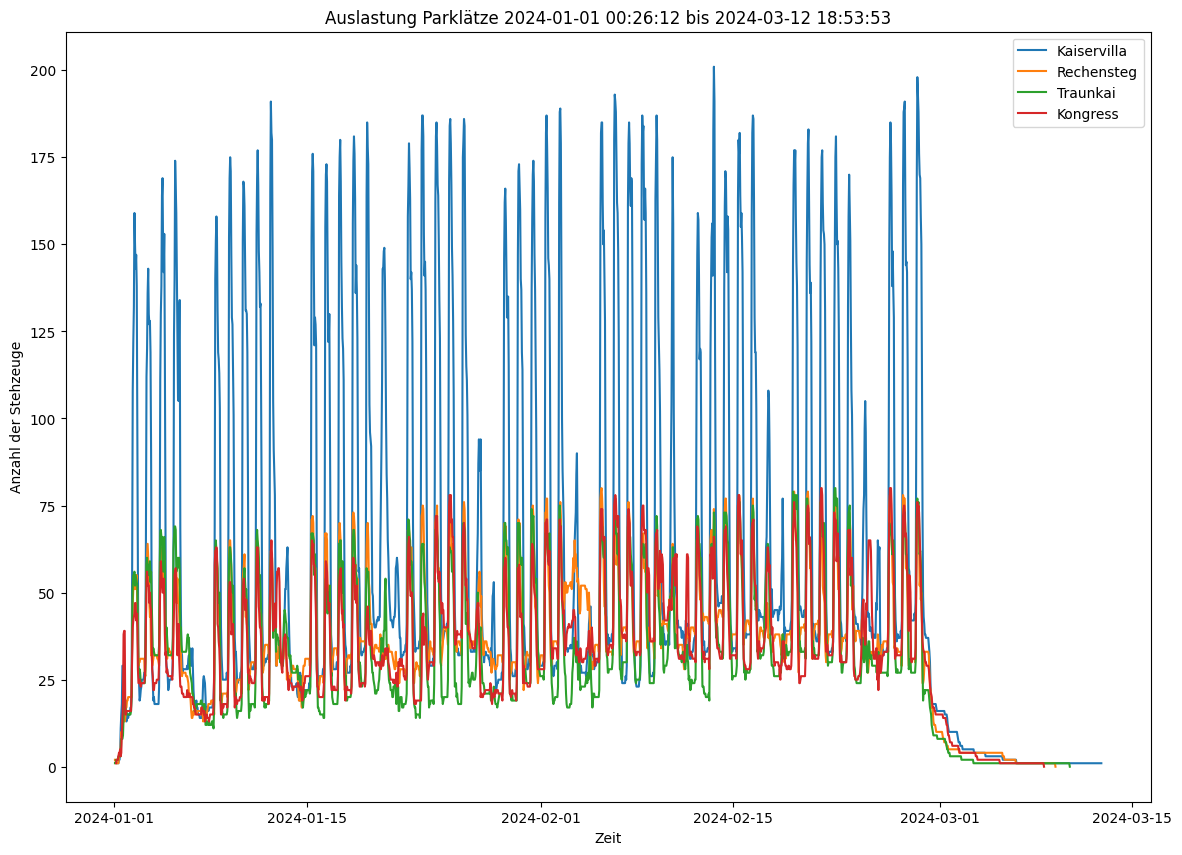

In [10]:
import matplotlib.pyplot as plt

def plot(df, start_date, end_date):
    
    filtered_df = df[ df['drive_in_at'].between(start_date, end_date) ]
    
    fig, ax = plt.subplots(figsize=(14, 10))  # Create a figure containing a single axes.
    ax.set_title(f"Auslastung Parklätze {start_date} bis {end_date}")
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Anzahl der Stehzeuge')
    
    #for data in [p_kaiservilla, p_kongress]
    for parking_lot in parking_lots:
        #print(parking_lot)
        p_data = filtered_df[filtered_df['gate_id_in'] == parking_lot['gate_id']]
        data = get_data_by_hour(p_data)
        x = []
        y = []
        for key in data:
            if start_date < key < end_date:
                #print(key, data[key])
                x.append(key)
                y.append(data[key]['counter'])
                
        ax.plot(x, y, label=f"{parking_lot['name']}")
    
    ax.legend()



plot(df, ts_start, ts_end)

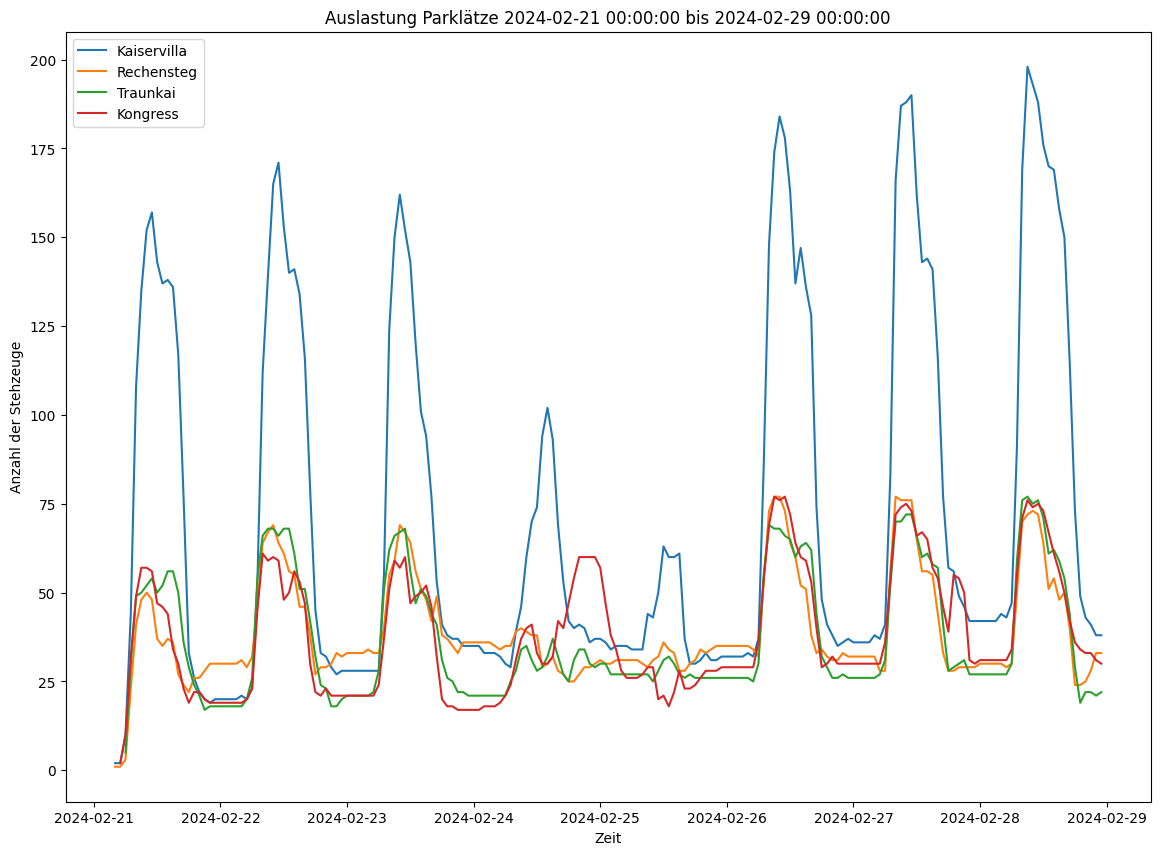

In [11]:
start_date = datetime(2024, 2, 21)
end_date = datetime(2024, 2, 29)
plot(df, start_date, end_date)

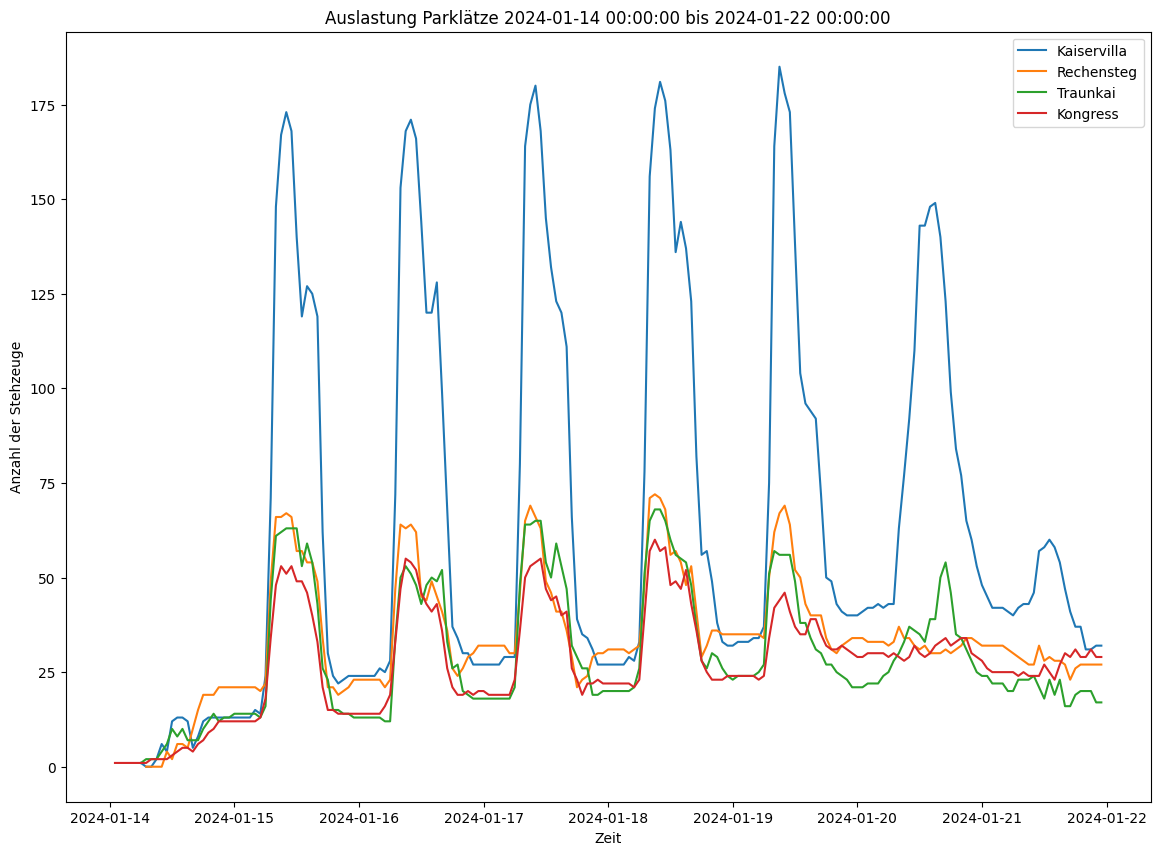

In [12]:
start_date = datetime(2024, 1, 14)
end_date = datetime(2024, 1, 22)
plot(df, start_date, end_date)